#Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
import zipfile
import pathlib
import os
import itertools

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

split-folders PyPI: Split folders with files (e.g. images) into train, validation and test (dataset) folders.

In [2]:
!pip install split-folders
import splitfolders

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset.zip' .
!unzip -q -n COVID-19_Radiography_Dataset.zip
data_dir = '/content/COVID-19_Radiography_Dataset'
#Dataset path = /content/COVID-19_Radiography_Dataset

In [5]:
# Setup some global variables
BATCH_SIZE = 64
IMG_SIZE = (299,299)

#2.1 Συνάρτηση prepare_datasets

In [6]:
def prepare_datasets(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(299, 299)):
    splitfolders.ratio(data_dir, output="/content/Data", ratio=(train_pct, val_pct, test_pct))

    # Get the subdirectories (classes)
    data_dir = pathlib.Path('/content/Data/test')
    classes = np.array(sorted(item.name for item in data_dir.glob("*")))

    # Test train validation split
    test_dir = '/content/Data/test'
    train_dir = '/content/Data/train'
    val_dir = '/content/Data/val'

    test_datagen = ImageDataGenerator(rescale = 1/255.)
    train_datagen = ImageDataGenerator(rescale = 1/255.)
    valid_datagen = ImageDataGenerator(rescale = 1/255.)

    test_ds = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                          color_mode = 'grayscale',
                                                          batch_size = BATCH_SIZE,
                                                          image_size = IMG_SIZE,
                                                          label_mode = 'categorical')

    train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                           color_mode = 'grayscale',
                                                           batch_size = BATCH_SIZE,
                                                           image_size = IMG_SIZE,
                                                           label_mode = 'categorical')

    val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_dir,
                                                         color_mode = 'grayscale',
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMG_SIZE,
                                                         label_mode = 'categorical')

    devel_ds = np.concatenate((train_ds, val_ds), axis=None)

    return devel_ds, train_ds, val_ds, test_ds, classes

#3 Απλό συνελικτικό δίκτυο

In [7]:
devel_ds, train_ds, val_ds, test_ds, class_names = prepare_datasets(data_dir="/content/COVID-19_Radiography_Dataset")

Copying files: 21165 files [00:07, 2671.25 files/s]


Found 4235 files belonging to 4 classes.
Found 12698 files belonging to 4 classes.
Found 4232 files belonging to 4 classes.


In [8]:
def cnn1(num_classes):
    model = tf.keras.Sequential([
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(8,3,activation="relu",input_shape = (299,299,3)),
      tf.keras.layers.MaxPooling2D(strides = 2),
      tf.keras.layers.Conv2D(16,3,activation="relu",input_shape = (299,299,3)),
      tf.keras.layers.MaxPooling2D(strides = 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(num_classes,activation="softmax")
    ])
    return model

In [9]:
model_1 = cnn1(num_classes=4)

In [10]:
# Compile Model 1
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-3,
                                                     beta_1 = 0.9,
                                                     beta_2 = 0.99 ),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ["accuracy"])

# Setup early callback
callback = tf.keras.callbacks.EarlyStopping(monitor ="loss",patience = 3)

# Fit the model
history_1 = model_1.fit(train_ds,
            batch_size = BATCH_SIZE,
            steps_per_epoch = len(train_ds),
            validation_data = val_ds,
            validation_steps = len(val_ds),
            epochs = 5,
            callbacks = [callback])

Epoch 1/5
199/199 [==============================] - 46s 166ms/step - loss: 1.1820 - accuracy: 0.5489 - val_loss: 0.7665 - val_accuracy: 0.6732
Epoch 2/5
199/199 [==============================] - 36s 173ms/step - loss: 0.6248 - accuracy: 0.7619 - val_loss: 0.5294 - val_accuracy: 0.8015
Epoch 3/5
199/199 [==============================] - 37s 184ms/step - loss: 0.4696 - accuracy: 0.8226 - val_loss: 0.4931 - val_accuracy: 0.8164
Epoch 4/5
199/199 [==============================] - 39s 193ms/step - loss: 0.3756 - accuracy: 0.8598 - val_loss: 0.4863 - val_accuracy: 0.8143
Epoch 5/5
199/199 [==============================] - 36s 171ms/step - loss: 0.2978 - accuracy: 0.8905 - val_loss: 0.5205 - val_accuracy: 0.8065


# 3.2 Αξιολόγηση

In [11]:
def create_and_plot_confusion(model, dataset, class_names = class_names, pre_trained = False):
    # Get predictions and labels
    if pre_trained:
        y_pred = model.predict(dataset)
        pred = np.argmax(y_pred, axis = 1)
        labels = np.argmax(dataset, axis = 1)
    else:
        pred = np.array([])
        labels = np.array([])
        for x , y in dataset:
            pred = np.concatenate([pred, np.argmax(model.predict(x), axis=-1)])
            labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

    # Create a confusion matrix
    confusion =  tf.math.confusion_matrix(labels=labels, predictions=pred).numpy()

    # Create multi class color plot for confusion matrix
    label_conf = np.arange(confusion.shape[0])
    fig , ax = plt.subplots(figsize=(16,16))
    cax = ax.matshow(confusion, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set(title="Confusion Matrix",
           xlabel="Predicted",
           ylabel="True",
           xticks = np.arange(len(class_names)),
           yticks = np.arange(len(class_names)),
           xticklabels = class_names,
           yticklabels = class_names)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (confusion.max() + confusion.min()) / 2.

    for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, f"{confusion[i, j]}",
                horizontalalignment="center",
                color="white" if confusion[i, j] > threshold else "black",
                size=14)

In [12]:
print(f" Training :{model_1.evaluate(train_ds)}")
print(f" Testing  :{model_1.evaluate(test_ds)}")
print(f" Valid    :{model_1.evaluate(val_ds)}")

199/199 [==============================] - 22s 107ms/step - loss: 0.2421 - accuracy: 0.9105
 Training :[0.2421218603849411, 0.91053706407547]
67/67 [==============================] - 7s 94ms/step - loss: 0.5410 - accuracy: 0.8104
 Testing  :[0.5410270690917969, 0.8103896379470825]
67/67 [==============================] - 9s 106ms/step - loss: 0.5205 - accuracy: 0.8065
 Valid    :[0.520484209060669, 0.806474506855011]


1/1 [==============================] - 0s 84ms/step


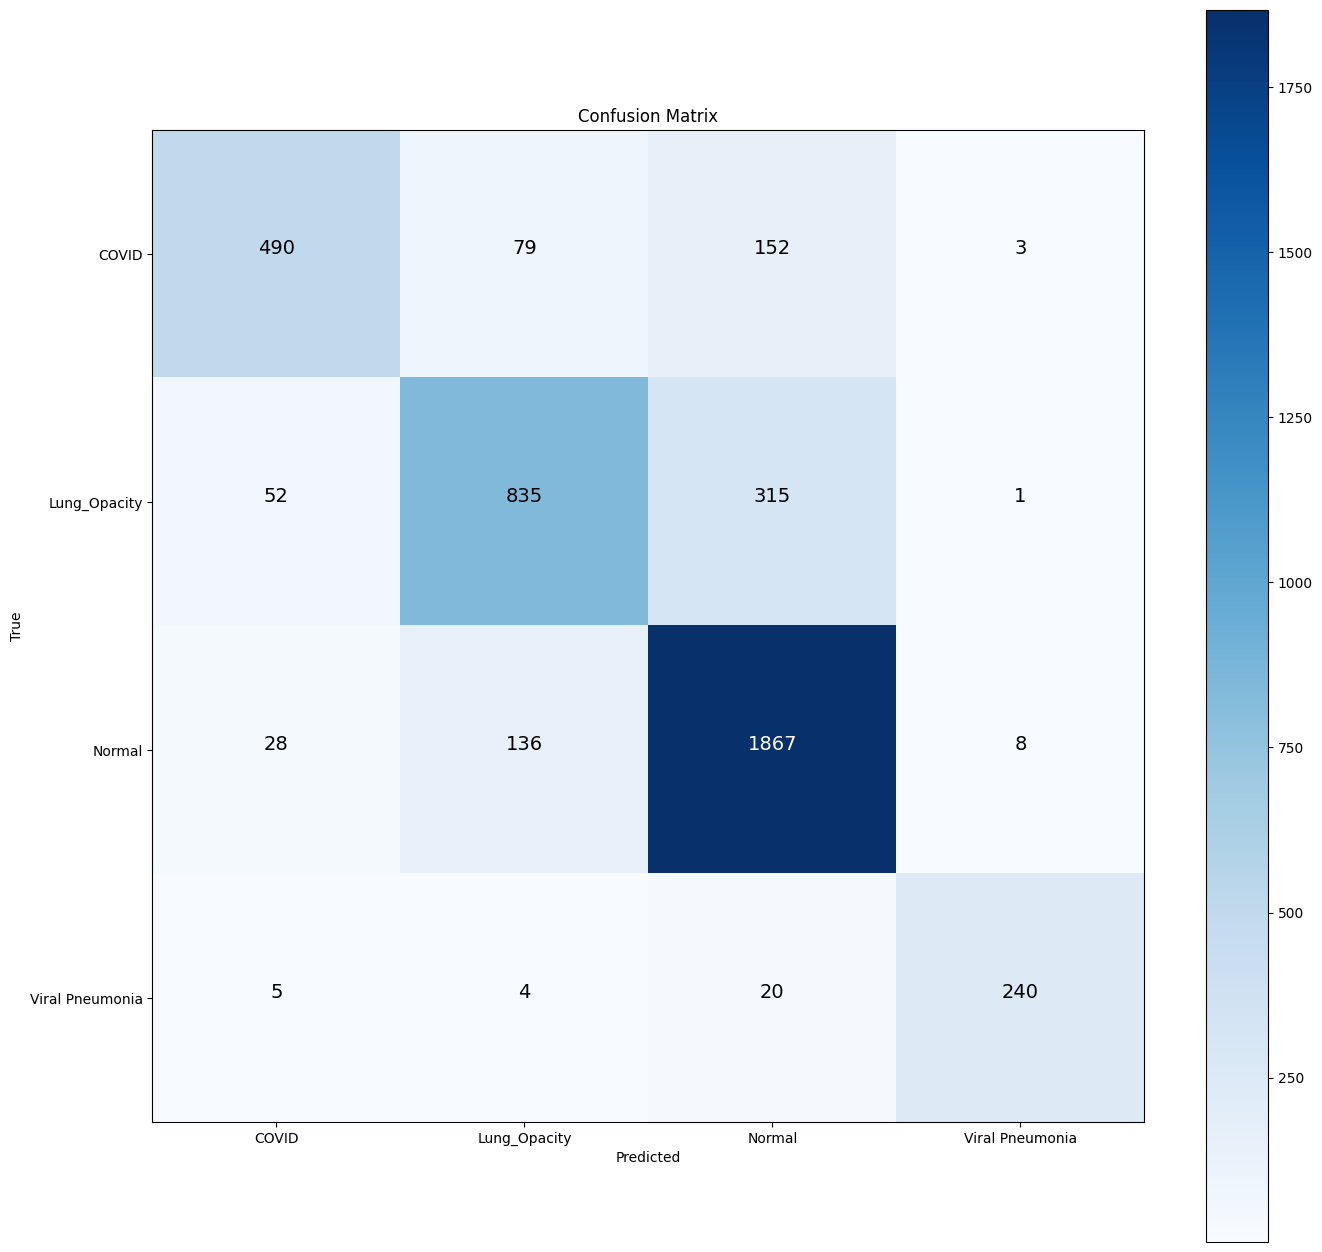

In [13]:
create_and_plot_confusion(model_1, test_ds)

# 4 Συνελικτικό δίκτυο μεγαλύτερου βάθους

In [14]:
def cnn2(num_classes):
    model = tf.keras.models.Sequential([
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.Conv2D(32,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.MaxPooling2D(strides = 4),

      tf.keras.layers.Conv2D(64,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.Conv2D(64,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.MaxPooling2D(strides = 2),

      tf.keras.layers.Conv2D(128,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.Conv2D(128,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.MaxPooling2D(strides = 2),

      tf.keras.layers.Conv2D(256,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.Conv2D(256,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.Conv2D(256,3,input_shape = (224,224,3),activation="relu"),
      tf.keras.layers.MaxPooling2D(strides = 2),

      tf.keras.layers.Conv2D(512, 3,input_shape = IMG_SIZE,activation="relu"),
      tf.keras.layers.MaxPooling2D(2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024, activation="relu"),
      tf.keras.layers.Dense(num_classes,activation="softmax")
    ])

    return model

In [16]:
# Create the model
model_2 = cnn2(len(class_names))

# Compile Model 2
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-3,
                                                     beta_1 = 0.9 ,
                                                     beta_2 =0.99 ),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ["accuracy"])

# Setup early callback
callback = tf.keras.callbacks.EarlyStopping(monitor ="loss",patience = 3)

# Fit the model
history_2 = model_2.fit(train_ds,
                        steps_per_epoch = len(train_ds),
                        epochs = 5,
                        batch_size = BATCH_SIZE,
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [callback])

Epoch 1/5
199/199 [==============================] - 81s 339ms/step - loss: 0.9908 - accuracy: 0.5813 - val_loss: 0.8685 - val_accuracy: 0.6281
Epoch 2/5
199/199 [==============================] - 63s 312ms/step - loss: 0.6934 - accuracy: 0.7265 - val_loss: 0.6455 - val_accuracy: 0.7509
Epoch 3/5
199/199 [==============================] - 61s 305ms/step - loss: 0.5863 - accuracy: 0.7740 - val_loss: 0.5392 - val_accuracy: 0.7956
Epoch 4/5
199/199 [==============================] - 60s 299ms/step - loss: 0.5193 - accuracy: 0.8015 - val_loss: 0.5162 - val_accuracy: 0.8039
Epoch 5/5
199/199 [==============================] - 61s 302ms/step - loss: 0.4446 - accuracy: 0.8331 - val_loss: 0.4879 - val_accuracy: 0.8299


In [17]:
print(f" Training :{model_2.evaluate(train_ds)}")
print(f" Testing  :{model_2.evaluate(test_ds)}")
print(f" Valid    :{model_2.evaluate(val_ds)}")

199/199 [==============================] - 26s 128ms/step - loss: 0.4127 - accuracy: 0.8501
 Training :[0.4126618802547455, 0.8500550985336304]
67/67 [==============================] - 9s 114ms/step - loss: 0.5156 - accuracy: 0.8201
 Testing  :[0.5155907273292542, 0.8200708627700806]
67/67 [==============================] - 10s 135ms/step - loss: 0.4879 - accuracy: 0.8299
 Valid    :[0.4878746569156647, 0.8298676609992981]


1/1 [==============================] - 0s 144ms/step


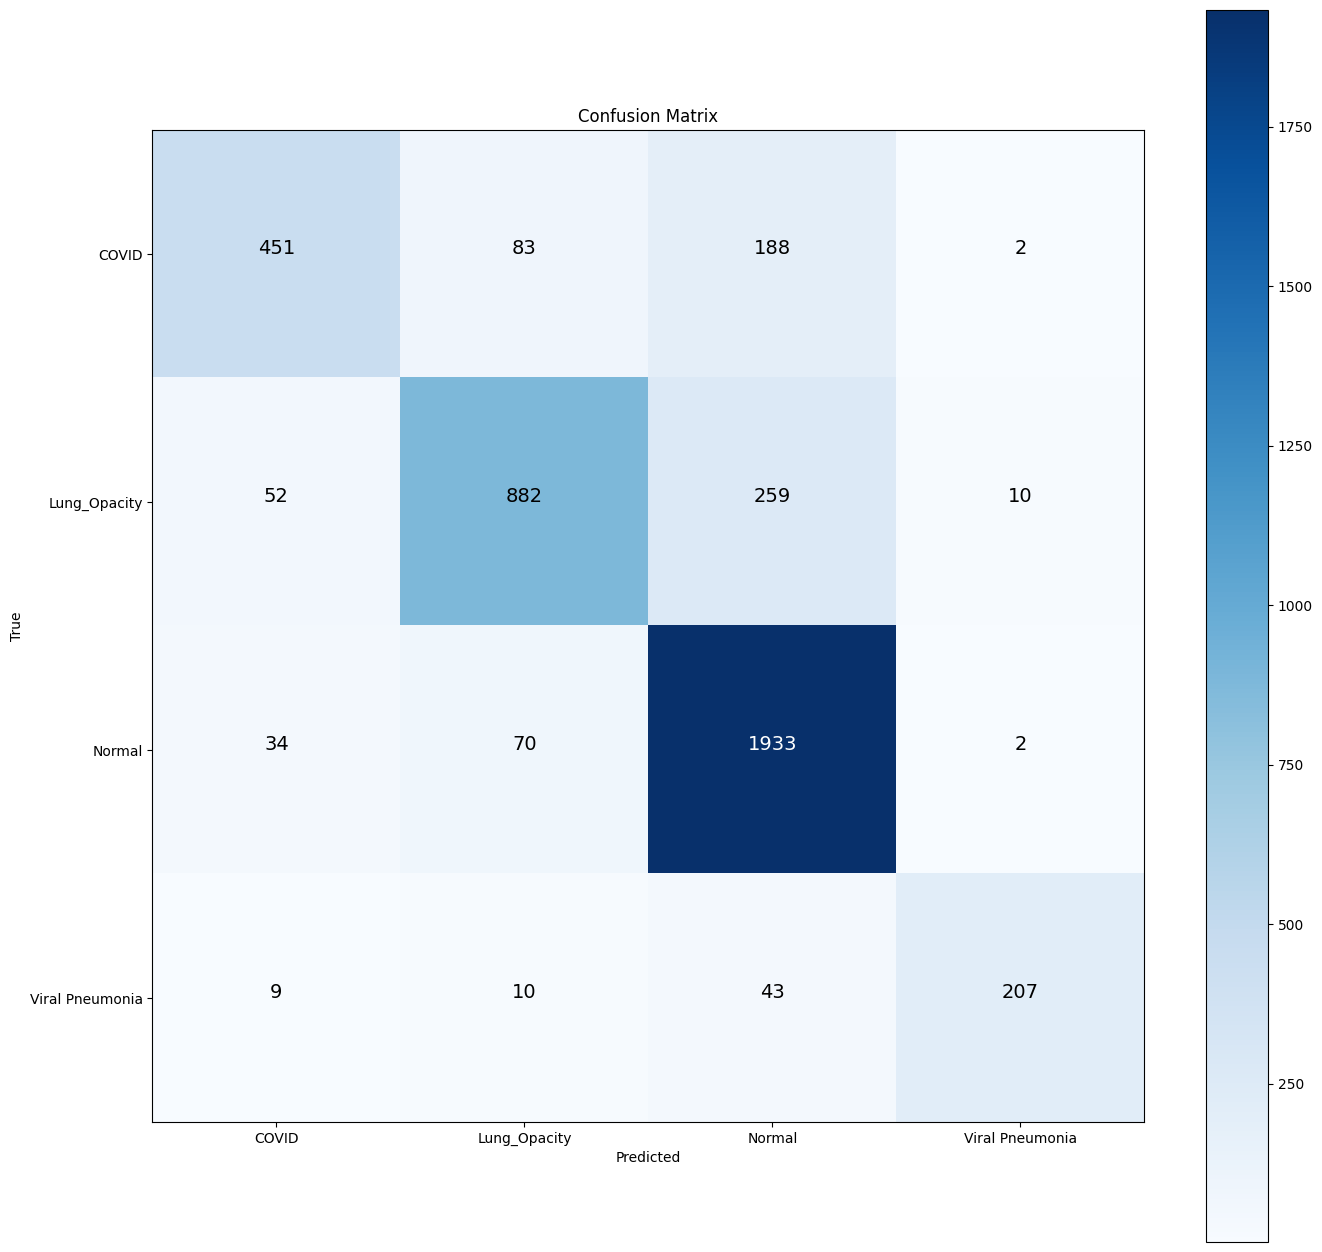

In [18]:
create_and_plot_confusion(model_2, test_ds)

# 5 Με χρήση προεκπαιδευμένου δικτύου

In [19]:
# Change global variables
BATCH_SIZE = 32
IMG_SIZE = (224,244)

# Test train validation split
train_dir = '/content/Data/train'
test_dir = '/content/Data/test'
val_dir = '/content/Data/val'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)
valid_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = "categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                                target_size = IMG_SIZE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = "categorical")

val_data = valid_datagen.flow_from_directory(val_dir,
                                                target_size = IMG_SIZE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = "categorical")

Found 12698 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [20]:
model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Create the efficientnet layer
feature_extractor_layer  = hub.KerasLayer(model_url,
                               trainable=False,
                               input_shape = IMG_SIZE+(3,))

output_size = len(class_names)

# Now time to create our own model
model_3  = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(output_size,activation="softmax")
])

# Compile Model 3
model_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-3,
                                                     beta_1 = 0.9 ,
                                                     beta_2 =0.99 ),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ["accuracy"])

# Setup early callback
callback = tf.keras.callbacks.EarlyStopping(monitor ="loss",patience = 3)

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs = 5,
                        batch_size = BATCH_SIZE,
                        validation_data = val_data,
                        callbacks = [callback])

Epoch 1/5
397/397 [==============================] - 80s 168ms/step - loss: 0.5428 - accuracy: 0.7997 - val_loss: 0.3992 - val_accuracy: 0.8471
Epoch 2/5
397/397 [==============================] - 63s 158ms/step - loss: 0.3772 - accuracy: 0.8653 - val_loss: 0.3380 - val_accuracy: 0.8776
Epoch 3/5
397/397 [==============================] - 64s 161ms/step - loss: 0.3313 - accuracy: 0.8828 - val_loss: 0.3196 - val_accuracy: 0.8811
Epoch 4/5
397/397 [==============================] - 65s 164ms/step - loss: 0.3037 - accuracy: 0.8912 - val_loss: 0.2965 - val_accuracy: 0.8906
Epoch 5/5
397/397 [==============================] - 63s 160ms/step - loss: 0.2870 - accuracy: 0.8991 - val_loss: 0.2862 - val_accuracy: 0.8984


In [21]:
print(f" Training :{model_3.evaluate(train_data)}")
print(f" Testing  :{model_3.evaluate(test_data)}")
print(f" Valid    :{model_3.evaluate(val_data)}")

397/397 [==============================] - 50s 125ms/step - loss: 0.2699 - accuracy: 0.9091
 Training :[0.2698715329170227, 0.9091195464134216]
133/133 [==============================] - 17s 128ms/step - loss: 0.2955 - accuracy: 0.8945
 Testing  :[0.2954769432544708, 0.8944510221481323]
133/133 [==============================] - 17s 124ms/step - loss: 0.2862 - accuracy: 0.8984
 Valid    :[0.2862044870853424, 0.8983932137489319]


In [ ]:
create_and_plot_confusion(model_3, test_data, pre_trained = True)